\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

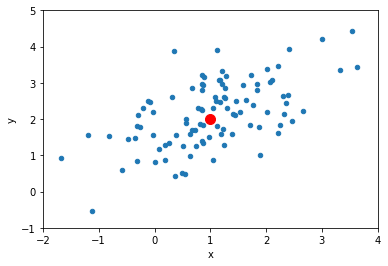

In [1]:
from scipy.stats import multivariate_normal
from pandas import DataFrame

rho = 0.6

mu = [1, 2]
sigma = [[1, rho], [rho, 1]]

dist = multivariate_normal(mean=mu, cov=sigma)
ax = DataFrame(dist.rvs(100), columns=['x', 'y']).plot(kind='scatter', x='x', y='y')
DataFrame([mu], columns=['x', 'y']).plot(kind='scatter', x='x', y='y', ax=ax, color='red', s=100)
ax.set(xlim=[-2, 4], ylim=[-1, 5]);

# 1. {-}

## (a) {-}

As the below realization of the error suggests, considering the mean squared prediction error, mean is a better estimator than median. 

In [1]:
from scipy.stats import expon
from numpy import abs
import numpy as np

mean = 1
median = np.log(2)
n = 1000

rvs = expon.rvs(size=n)

print(((rvs - mean)**2).mean())    # mean squared error of the mean
print(((rvs - median)**2).mean())  # mean squared error of the median

1.075383043650204
1.1883149611307744


## (b) {-}

In contrast, considering the mean absolute prediction error, median is a (slightly) better estimator than mean. 

In [2]:
rvs = expon.rvs(size=n)

print((abs(rvs - mean)).mean())    # mean absolute error of the mean 
print((abs(rvs - median)).mean())  # mean absolute error of the median

0.7655840643978613
0.7291958553195591


# 2. {-}

## (a) {-}

Below is a plot of the loss function 
\begin{align*}
\mathcal L(Y, f(X)) &= b\left(e^{a(Y-f(X))} - a(Y-f(X)) - 1\right) \\
&= b\left(e^{az} - az - 1\right). 
\end{align*}

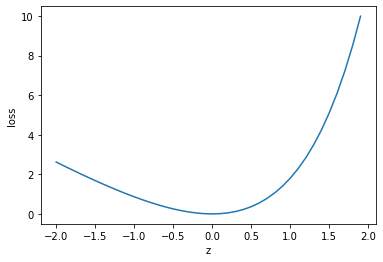

In [3]:
from numpy import exp
from pandas import DataFrame

a = 1.1
b = 2

loss = lambda z: b*(exp(a*z) - a*z -1)
    
ax = DataFrame([(x, loss(x)) for x in np.arange(-2, 2, 0.1)], columns=['z', 'loss']).set_index('z').plot(legend=None)
ax.set_ylabel('loss')
ax.set_xlabel('z');

This is known as the LINEX loss function. Roughly speaking, on the right (when $z>0$) the loss goes up exponentially with the absolute prediction error, while on the left ($z<0$) it only goes up linearly with the absolute prediction error. 

Note that $z = Y - f(X) > 0$ means $f(X)$ underestimates $Y$ while $z<0$ means $f(X)$ overestimates $Y$. We might choose to use this loss function when the consequences of underestimating are much more serious than overestimating. An example could be to estimate a bank's value at risk, where underestimating could result in insufficient reserve and a default event, while the only consequence of overestimating is slight inefficiency in funding and is minor. Another example is to predict the stock price at some point in time in the future and write a naked call option based on that prediction, in which case a serious underestimating of the stock price means the option expires deep in the money and the writer takes a huge loss, while overestimating simply means the writer could have collected more premium by writing an option with a lower strike. 

## (b) {-}

The expected loss is
\begin{align}
\mathbb E\mathcal L(Y, f(X)) &= \mathbb E[\mathbb E[ b(e^{a(Y-f(X))} - a(Y-f(X)) -1) |X]]\\
&= \mathbb E[b \mathbb E[e^{a(Y-f(X))}|X] - abE[Y-f(X)|X] -b]\\
&= \mathbb E[b e^{-af(X)}\mathbb E[e^{aY}|X] - abE[Y|X] + abf(X) -b], 
\end{align}
which is minimized when the integrand $b e^{-af(x)}\mathbb E[e^{aY}|X=x] - abE[Y|X=x] + abf(x) -b$ is minimized for a given $x$. 
Differentiate with respect to $f(x)$ and set to zero to get $-ab e^{f(x)}\mathbb E[e^{aY}|X=x] + ab = 0$, or equivalently 
\begin{align}
f(x) = \frac{1}{a}\log\mathbb E[e^{aY}|X=x]. 
\end{align}
Since $a, b > 0$, the second derivative of the integrand is $-ab e^{f(x)}\mathbb E[e^{aY}|X=x] < 0$. Thus we conclude that $f(x) = (\log\mathbb E[e^{aY}|X=x])/a$ minimizes the expected loss. 

## (c) {-}

Since $(Y|X=x) \sim N(\beta x, \sigma^2)$, we have $\mathbb E[e^{aY}|X=x] = e^{a\beta x + \frac12 a^2\sigma^2}$. Thus the optimal estimator $f(x)$ is 
\begin{align}
f(x) = \frac{1}{a}\log\mathbb E[e^{aY}|X=x] = \beta x + \frac{a}{2} \sigma^2.
\end{align}

## (d) {-}

Following the above result, the ```f_yours``` function is implemented to return ```beta*x + 0.5*a*sigma**2```. The simulation results are as below. 

In [4]:
!python asymm_loss.py

Average loss of the conditional expectation: 16.36
Average loss of your method: 4.49


The average loss computed using the optimal estimator $f(X) = \beta X + a\sigma^2/2$ is indeed much smaller than the average loss computed using the conditional expectation $\beta X$. Intuitively this makes sense because this version of the LINEX loss function we are looking at penalizes more when underestimating and the optimal estimator is larger than the conditional expectation by $a\sigma^2/2$. Because of this (positive) adjustment, the optimal estimator are less likely to underestimate. Without this adjustment, the conditional expectation is expected to underestimate more often than the optimal estimator and as a result makes the average loss larger. 

# 3. {-}

As the results shown below, the more useless additional variables there are, the larger the average mean squared prediction error is. Below 100 simulations are performed for each $p$. 

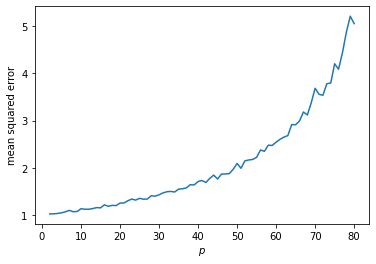

In [3]:
from scipy.stats import norm
from pandas import Series, DataFrame
import statsmodels.api as sm
import numpy as np

n_sim = 100

n = 100
m = 100
p = 2

def mse(p):
    trainX = DataFrame({'X%02d'%(i+1) : norm.rvs(size=n) for i in range(p)})
    trainY = 4*trainX['X01'] + norm.rvs(size=n)

    testX = DataFrame({'X%02d'%(i+1) : norm.rvs(size=m) for i in range(p)})
    testY = 4*testX['X01'] + norm.rvs(size=m)

    model = sm.OLS(exog=trainX, endog=trainY).fit()
    return ((testY - (testX @ model.params))**2).mean()
        
def avg_mse(p):
    return np.mean([mse(p) for _ in range(n_sim)])    

ax = Series({p: avg_mse(p) for p in range(2, 81)}).plot()
ax.set_ylabel('mean squared error')
ax.set_xlabel('$p$');